In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import ThreeCNN, ThreeCNN_Module, rnn_2dCNN
from train import check_accuracy, train, train_ThreeCNN
from plottingFcts import trainingMetrics, sigBkgEff, plotROC
from imageNumber_analysis import num_valAcc 

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
#batch_size = 1024
#loader_train, loader_val, loader_test = getDataLoaders(batch_size=batch_size, N=90000)

In [11]:
"""
layer0_params_2 = [128, 3, 3, 1, 1]
layer0_reduce_2 = [1, 3, 93, 1, 1] # ---> Downsampling with one filter at the end

layer1_params_2 = [128, 3, 3, 1, 1]
layer1_reduce_2 = [1, 12, 9, 1, 1] # ---> Downsampling with one filter 

layer2_params_2 = [128, 3, 3, 1, 1]
layer2_reduce_2 = [1, 12, 3, 1, 1] # ---> downsampling with one filter 

rnn_params_2 = [18, 18, 1]

layer3_params_2 = [32, 3, 3, 1, 1]

fc_params_2 = [18, 150, 100, 50, 3, 0.5]
print(batch_size*rnn_params_2[1])
"""

'\nlayer0_params_2 = [128, 3, 3, 1, 1]\nlayer0_reduce_2 = [1, 3, 93, 1, 1] # ---> Downsampling with one filter at the end\n\nlayer1_params_2 = [128, 3, 3, 1, 1]\nlayer1_reduce_2 = [1, 12, 9, 1, 1] # ---> Downsampling with one filter \n\nlayer2_params_2 = [128, 3, 3, 1, 1]\nlayer2_reduce_2 = [1, 12, 3, 1, 1] # ---> downsampling with one filter \n\nrnn_params_2 = [18, 18, 1]\n\nlayer3_params_2 = [32, 3, 3, 1, 1]\n\nfc_params_2 = [18, 150, 100, 50, 3, 0.5]\nprint(batch_size*rnn_params_2[1])\n'

In [13]:
"""
rnn_model = rnn_2dCNN(layer0_params_2, layer0_reduce_2, layer1_params_2, layer1_reduce_2, layer2_params_2, layer2_reduce_2, rnn_params_2, layer3_params_2, fc_params_2)

optimizer = optim.Adam(rnn_model.parameters(), lr=1e-5)

hist, bestModel = train(loader_train, loader_val, rnn_model, optimizer, epochs=5, returnBest=True)
"""

'\nrnn_model = rnn_2dCNN(layer0_params_2, layer0_reduce_2, layer1_params_2, layer1_reduce_2, layer2_params_2, layer2_reduce_2, rnn_params_2, layer3_params_2, fc_params_2)\n\noptimizer = optim.Adam(rnn_model.parameters(), lr=1e-5)\n\nhist, bestModel = train(loader_train, loader_val, rnn_model, optimizer, epochs=5, returnBest=True)\n'

# Analyzing number of training images vs validation accuracy, using function defined in imageNumber_analysis

In [3]:
layer0_params = [32, 3, 3, 1, 1]
layer0_reduce = [1, 3, 93, 1, 1] # ---> Downsampling with one filter at the end

layer1_params = [32, 3, 3, 1, 1]
layer1_reduce = [1, 12, 9, 1, 1] # ---> Downsampling with one filter 

layer2_params = [32, 3, 3, 1, 1]
layer2_reduce = [1, 12, 3, 1, 1] # ---> downsampling with one filter 

rnn_params = [18, 18, 1]

layer3_params = [32, 3, 3, 1, 1]

fc_params = [18, 150, 100, 50, 3, 0.5]

In [4]:
all_params = [layer0_params, layer0_reduce, layer1_params, layer1_reduce, layer2_params, layer2_reduce, rnn_params, layer3_params, fc_params]

In [5]:
num_images = [10, 100, 1000, int(1e4), int(2e4), int(4e4), int(6e4), int(7e4), int(8e4), int(9e4), int(1e5)]
learn_rate = 1e-5
epochs = 10
batch_size = 64

Finished training with 10 images.
Best val accuracy: 0.666667
________________________________________________
Finished training with 100 images.
Best val accuracy: 0.300000
________________________________________________
Finished training with 1000 images.
Best val accuracy: 0.450000
________________________________________________
Finished training with 10000 images.
Best val accuracy: 0.659667
________________________________________________
Finished training with 20000 images.
Best val accuracy: 0.720833
________________________________________________
Finished training with 40000 images.
Best val accuracy: 0.754583
________________________________________________
Finished training with 60000 images.
Best val accuracy: 0.758889
________________________________________________
Finished training with 70000 images.
Best val accuracy: 0.764333
________________________________________________
Finished training with 80000 images.
Best val accuracy: 0.760083
_____________________________

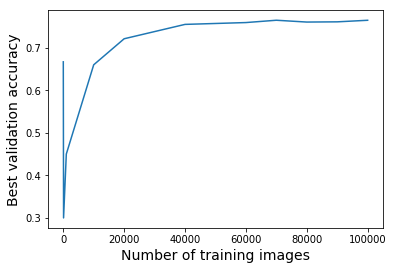

In [6]:
best_models = num_valAcc(num_images, all_params, learn_rate, epochs, batch_size)

In [8]:
# save the models returned by the above function 
for model in best_models: 
    torch.save(best_models[model].state_dict(), "../models/NumImages_Val_Models/{}.pth.tar".format(model))

Given the above, we see that the best validation accuracy achieved in 10 epochs is approximately constant after 20,000 images. So, to avoid underfitting, we'll start by training a model on approx 20,000 images, instead of the full 100,000.

In [10]:
batch_size = 1024
#loader_train, loader_val, loader_test = getDataLoaders(batch_size=batch_size, N=20000)

In [16]:
layer0_params_2 = [32, 3, 3, 1, 1]
layer0_reduce_2 = [1, 3, 93, 1, 1] # ---> Downsampling with one filter at the end

layer1_params_2 = [32, 3, 3, 1, 1]
layer1_reduce_2 = [1, 12, 9, 1, 1] # ---> Downsampling with one filter 

layer2_params_2 = [32, 3, 3, 1, 1]
layer2_reduce_2 = [1, 12, 3, 1, 1] # ---> downsampling with one filter 

rnn_params_2 = [18, 18, 1]

layer3_params_2 = [32, 3, 3, 1, 1]

fc_params_2 = [18, 150, 100, 50, 3, 0.5]

In [23]:
rnn_model = rnn_2dCNN(layer0_params_2, layer0_reduce_2, layer1_params_2, layer1_reduce_2, layer2_params_2, layer2_reduce_2, rnn_params_2, layer3_params_2, fc_params_2)

optimizer = optim.Adam(rnn_model.parameters(), lr=1e-5)

hist, bestModel = train(loader_train, loader_val, rnn_model, optimizer, epochs=10, returnBest=True, verbose=True)


Epoch 1/10:
Iteration 0, loss = 1.1302
cuda
Got 8734 / 26999 correct (32.35)

Iteration 100, loss = 1.0788
cuda
Got 10988 / 26999 correct (40.70)

cuda
Got 70780 / 162000 correct (43.69)
cuda
Got 11655 / 26999 correct (43.17)

Epoch 2/10:
Iteration 0, loss = 1.0672
cuda
Got 11746 / 26999 correct (43.51)

Iteration 100, loss = 1.0249
cuda
Got 12864 / 26999 correct (47.65)

cuda
Got 80534 / 162000 correct (49.71)
cuda
Got 13482 / 26999 correct (49.94)

Epoch 3/10:
Iteration 0, loss = 1.0167
cuda
Got 13498 / 26999 correct (49.99)

Iteration 100, loss = 1.0135
cuda
Got 14456 / 26999 correct (53.54)

cuda
Got 88945 / 162000 correct (54.90)
cuda
Got 14701 / 26999 correct (54.45)

Epoch 4/10:
Iteration 0, loss = 0.9896
cuda
Got 14776 / 26999 correct (54.73)

Iteration 100, loss = 0.9686
cuda
Got 15503 / 26999 correct (57.42)

cuda
Got 94912 / 162000 correct (58.59)
cuda
Got 15875 / 26999 correct (58.80)

Epoch 5/10:
Iteration 0, loss = 0.9637
cuda
Got 15830 / 26999 correct (58.63)

Iteration

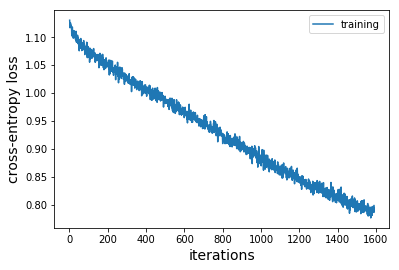

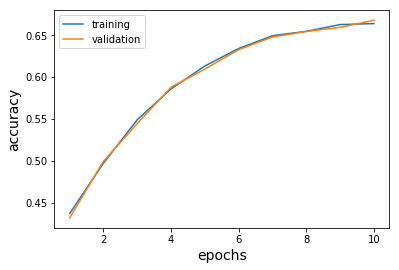

In [24]:
trainingMetrics(hist)

We still see the training and validation accuracies tracking very close togther! 

Perhaps this isn't a bad thing, given how similar most of our images are. Let's try running the same function, but for more epochs and with more filters. I'm curious to see how the number of parameters affects the overall model performance. 

In [11]:
batch_size = 1024
loader_train, loader_val, loader_test = getDataLoaders(batch_size=batch_size, N=40000)

In [5]:
layer0_params_3 = [64, 3, 3, 1, 1]
layer0_reduce_3 = [1, 3, 93, 1, 1] # ---> Downsampling with one filter at the end

layer1_params_3 = [64, 3, 3, 1, 1]
layer1_reduce_3 = [1, 12, 9, 1, 1] # ---> Downsampling with one filter 

layer2_params_3 = [64, 3, 3, 1, 1]
layer2_reduce_3 = [1, 12, 3, 1, 1] # ---> downsampling with one filter 

rnn_params_3 = [18, 18, 1]

layer3_params_3 = [32, 3, 3, 1, 1]

fc_params_3 = [18, 150, 100, 50, 3, 0.5]

In [6]:
rnn_model_3 = rnn_2dCNN(layer0_params_3, layer0_reduce_3, layer1_params_3, layer1_reduce_3, layer2_params_3, layer2_reduce_3, rnn_params_3, layer3_params_3, fc_params_3)

optimizer_3 = optim.Adam(rnn_model_3.parameters(), lr=1e-5)

hist_3, bestModel_3 = train(loader_train, loader_val, rnn_model_3, optimizer_3, epochs=20, returnBest=True, verbose=True)


Epoch 1/20:
Iteration 0, loss = 1.1379
cuda
Got 1947 / 6000 correct (32.45)

cuda
Got 13755 / 36000 correct (38.21)
cuda
Got 2339 / 6000 correct (38.98)

Epoch 2/20:
Iteration 0, loss = 1.0973
cuda
Got 2302 / 6000 correct (38.37)

cuda
Got 14627 / 36000 correct (40.63)
cuda
Got 2457 / 6000 correct (40.95)

Epoch 3/20:
Iteration 0, loss = 1.0758
cuda
Got 2491 / 6000 correct (41.52)

cuda
Got 15495 / 36000 correct (43.04)
cuda
Got 2542 / 6000 correct (42.37)

Epoch 4/20:
Iteration 0, loss = 1.0697
cuda
Got 2547 / 6000 correct (42.45)

cuda
Got 16307 / 36000 correct (45.30)
cuda
Got 2719 / 6000 correct (45.32)

Epoch 5/20:
Iteration 0, loss = 1.0478
cuda
Got 2733 / 6000 correct (45.55)

cuda
Got 16918 / 36000 correct (46.99)
cuda
Got 2884 / 6000 correct (48.07)

Epoch 6/20:
Iteration 0, loss = 1.0152
cuda
Got 2811 / 6000 correct (46.85)

cuda
Got 17425 / 36000 correct (48.40)
cuda
Got 2914 / 6000 correct (48.57)

Epoch 7/20:
Iteration 0, loss = 1.0035
cuda
Got 2887 / 6000 correct (48.12)

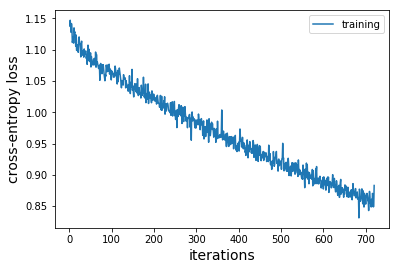

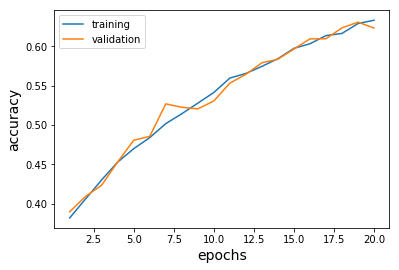

In [7]:
trainingMetrics(hist_3)

In [8]:
layer0_params_4 = [64, 3, 3, 1, 1]
layer0_reduce_4 = [1, 3, 93, 1, 1] # ---> Downsampling with one filter at the end

layer1_params_4 = [64, 3, 3, 1, 1]
layer1_reduce_4 = [1, 12, 9, 1, 1] # ---> Downsampling with one filter 

layer2_params_4 = [64, 3, 3, 1, 1]
layer2_reduce_4 = [1, 12, 3, 1, 1] # ---> downsampling with one filter 

rnn_params_4 = [18, 18, 1]

layer3_params_4 = [32, 3, 3, 1, 1]

fc_params_4 = [18, 150, 100, 50, 3, 0.5]

In [12]:
rnn_model_4 = rnn_2dCNN(layer0_params_4, layer0_reduce_4, layer1_params_4, layer1_reduce_4, layer2_params_4, layer2_reduce_4, rnn_params_4, layer3_params_4, fc_params_4)

optimizer_4 = optim.Adam(rnn_model_4.parameters(), lr=1e-5)

hist_4, bestModel_4 = train(loader_train, loader_val, rnn_model_4, optimizer_4, epochs=20, returnBest=True, verbose=True)


Epoch 1/20:
Iteration 0, loss = 1.1222
cuda
Got 4127 / 12000 correct (34.39)

cuda
Got 29836 / 72000 correct (41.44)
cuda
Got 4974 / 12000 correct (41.45)

Epoch 2/20:
Iteration 0, loss = 1.0622
cuda
Got 4972 / 12000 correct (41.43)

cuda
Got 32938 / 72000 correct (45.75)
cuda
Got 5446 / 12000 correct (45.38)

Epoch 3/20:
Iteration 0, loss = 1.0351
cuda
Got 5550 / 12000 correct (46.25)

cuda
Got 35530 / 72000 correct (49.35)
cuda
Got 5870 / 12000 correct (48.92)

Epoch 4/20:
Iteration 0, loss = 1.0090
cuda
Got 5921 / 12000 correct (49.34)

cuda
Got 37704 / 72000 correct (52.37)
cuda
Got 6373 / 12000 correct (53.11)

Epoch 5/20:
Iteration 0, loss = 0.9823
cuda
Got 6312 / 12000 correct (52.60)

cuda
Got 39835 / 72000 correct (55.33)
cuda
Got 6637 / 12000 correct (55.31)

Epoch 6/20:
Iteration 0, loss = 0.9604
cuda
Got 6720 / 12000 correct (56.00)

cuda
Got 41206 / 72000 correct (57.23)
cuda
Got 6843 / 12000 correct (57.03)

Epoch 7/20:
Iteration 0, loss = 0.9382
cuda
Got 6781 / 12000 co

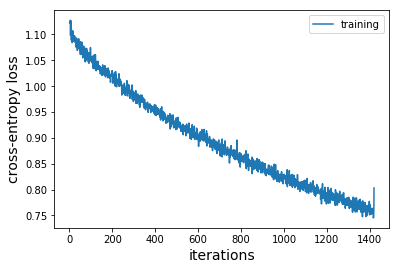

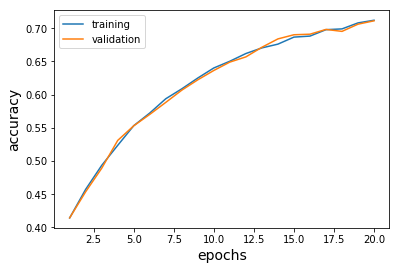

In [13]:
trainingMetrics(hist_4)